# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

## Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
from statannotations.Annotator import Annotator

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *
from parsers import extract_FOV_area

# Figures dictionary
figs = {}

## Parameters

### Input datasets and main processing parameters

In [3]:
# Processing parameters
analysis_type = 'main'  # Analysis type
mouseline = 'pv'  # mouse line
layer = None  # cortical layer
slack_notify = False
global_correction = GLOBAL_CORRECTION  # global stack correction method
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
do_nonstat_correct = True  # whether to perform non-stationarity correction

# Plotting parameters
xkeys_plt = [  # input parameters
    Label.P,
    Label.DC,
    Label.ISPTA
]
ykeys_plt = [  # plotting variables
    Label.DFF,
    Label.ZSCORE, 
    # Label.EVENT_RATE
]
plot_rasters = False  # whether to render raster plots of population activity, or not
plot_traces = True
skip_osc_analysis = True  # whether to skip oscillation analysis

### Derived parameters

In [4]:
# Get batch-related settings
dataset_group_id, input_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, global_correction, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_id = get_baseline_id(baseline_quantile, baseline_wquantile, baseline_wsmoothing)

ispv = mouseline == 'pv'
isnotpv = not ispv

# Set ON/OFF execution flags
skip_rasters = not plot_rasters
skip_traces = not plot_traces
 
# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} {analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2023/10/27 14:00:43: assembling batch analysis settings...
 2023/10/27 14:00:43: pv main analysis notebook started on 2023-10-27 at 14:00:43


### Input summary table figure

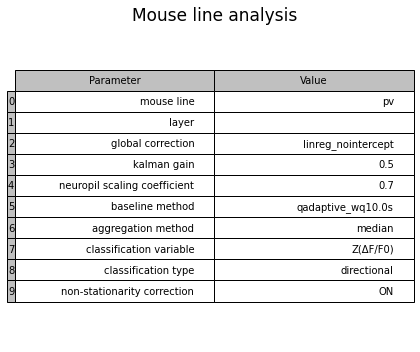

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'global correction': global_correction,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline method': baseline_id,
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional",
    'non-stationarity correction': 'ON' if do_nonstat_correct else 'OFF',
    }, title='Mouse line analysis', aspect=1.5)

## Load & inspect initial data

### Load data

In [6]:
# Determine exclude patterns
# from excludes import main_excludes
# exclude_patterns = list(set(main_excludes[mouseline]))
exclude_patterns = None

# Determine what to do in case of duplicate runs
on_duplicate_runs = 'drop'

# Load datasets
logger.info(f'loading data from {input_dir}:')
data = load_processed_datasets(
    input_dir, layer=layer,
    exclude_patterns=exclude_patterns,
    on_duplicate_runs=on_duplicate_runs)
logger.info('data successfully loaded.')

 2023/10/27 14:00:46: loading data from /gpfs/scratch/lemait01/data/usnm/processed/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/linreg_nointercept/submap_0<-1_9->10every100/main/pv:
 2023/10/27 14:00:46: gathering dataset IDs...
 2023/10/27 14:00:47: loading mouse-region data from 20190606_mouse2_region1.h5
 2023/10/27 14:00:47: loading mouse-region data from 20190606_mouse2_region2.h5
 2023/10/27 14:00:47: loading mouse-region data from 20190629_mouse2_region1.h5
 2023/10/27 14:00:47: loading mouse-region data from 20190630_mouse3_region1.h5
 2023/10/27 14:00:48: loading mouse-region data from 20190702_mouse1_region1.h5
 2023/10/27 14:00:48: loading mouse-region data from 20190702_mouse5_region1.h5
 2023/10/27 14:00:48: loading mouse-region data from 20190703_mouse4_region1.h5
 2023/10/27 14:00:48: loading mouse-region data from 20190821_mouse3_region1.h5
 2023/10/27 14:00:48: loading mouse-region data from 20190821

### Unpack data and get ROI counts

In [7]:
# Unpack
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, map_ops = extract_from_batch_data(data)

# Display ROI count per dataset & run, and highlight incomplete datasets
logger.info('detailed ROI count:')
get_detailed_ROI_count(trialagg_stats, style=True)

 2023/10/27 14:00:55: extracting timeseries and stats from data...
 2023/10/27 14:00:55: detailed ROI count:


run,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
P (MPa),0.00,0.05,0.10,0.20,0.40,0.60,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80
DC (%),50,50,50,50,50,50,05,10,20,30,40,50,60,70,80
dataset,,,,,,,,,,,,,,,
20190606_mouse2_region1,103,nan,nan,103,103,103,103,103,103,103,103,103,nan,nan,nan
20190606_mouse2_region2,80,nan,nan,80,80,80,80,80,80,80,80,80,nan,nan,nan
20190629_mouse2_region1,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51
20190630_mouse3_region1,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47
20190702_mouse1_region1,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132
20190702_mouse5_region1,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63
20190703_mouse4_region1,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76


### Inspect cell maps and exclude outlier datasets 

 2023/10/27 14:00:57: sorted cell densities:
dataset
20190821_mouse3_region1    181.108148
20190630_mouse3_region1    185.045282
20190821_mouse7_region1    188.982416
20190629_mouse2_region1    200.793817
20190821_mouse6_region1    228.353752
20190702_mouse5_region1    248.039420
20190703_mouse4_region1    299.222158
20190606_mouse2_region2    314.970693
20190606_mouse2_region1    405.524767
20190702_mouse1_region1    519.701643
dtype: float64
 2023/10/27 14:00:57: plotting cell maps...


100%|██████████| 10/10 [00:00<00:00, 66.82it/s]

 2023/10/27 14:00:57: empty exclude list -> ignoring


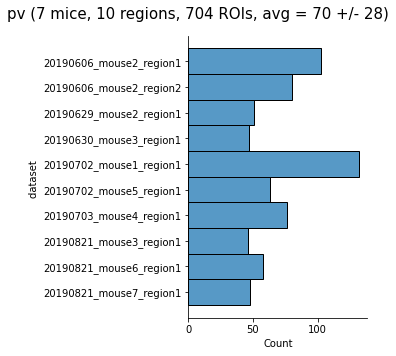

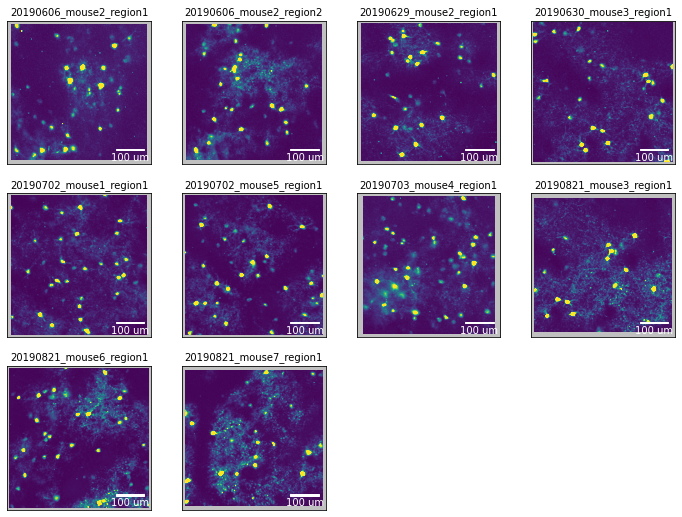

In [8]:
figs['cellcounts'] = plot_cellcounts(trialagg_stats, hue=None, title=mouseline)

# Compute ROI density for each dataset
FOV_areas = pd.Series({k: extract_FOV_area(v) for k, v in map_ops.items()})  # mm2
ROI_counts = get_detailed_ROI_count(trialagg_stats).max(axis=1).astype(int)  # cells
ROI_densities = ROI_counts / FOV_areas  # cells/mm2
logger.info(f'sorted cell densities:\n{ROI_densities.sort_values()}')

# If threshold on cell density is specified, exclude datasets with densities below threshold 
from constants import MIN_CELL_DENSITY
outliers = None
if MIN_CELL_DENSITY[mouseline] is not None:
    isoutlier = ROI_densities < MIN_CELL_DENSITY[mouseline]
    outliers = isoutlier[isoutlier].index.values.tolist()
    if len(outliers) > 0:
        logger.warning(f'datasets with abnormally low cell density::\n{pprint.pformat(outliers)}')
    figs['cellcounts'].axes[0].axvline(
        MIN_CELL_DENSITY[mouseline] * FOV_areas.mean(), c='k', ls='--')

# Plot cell maps and highlight outlier datasets
figs['cellmaps'] = plot_fields_of_view(
    map_ops, 
    refkey='max_proj',  # 'Vcorr', 
    # ROI_masks=ROI_masks, 
    Fstats=trialagg_stats, 
    mode='contour', 
    hue=None, 
    outliers=outliers,
    # qmin=.2,
    qmax=.99
)

# Exclude outlier datasets
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = exclude_datasets(
    trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, to_exclude=outliers)

### Inspect baseline variation throughout experiments and exclude outlier datasets

 2023/10/27 14:00:59: inspecting relative variations in baseline fluorescence across experiments...
 2023/10/27 14:00:59: maximal relative FO deviations:
dataset
20190606_mouse2_region1    0.019573
20190630_mouse3_region1    0.044714
20190606_mouse2_region2    0.047189
20190821_mouse6_region1    0.067961
20190821_mouse7_region1    0.111016
20190702_mouse1_region1    0.122612
20190703_mouse4_region1    0.147452
20190629_mouse2_region1    0.161859
20190702_mouse5_region1    0.185748
20190821_mouse3_region1    0.370595
Name: rel F0 (a.u.), dtype: float64
 2023/10/27 14:00:59: identified 1 datasets with abnormal baseline fluorescence variations:
  - 20190821_mouse3_region1
 2023/10/27 14:00:59: excluding the following datasets from analysis:
 - 20190821_mouse3_region1
 2023/10/27 14:00:59: 9 datasets remaining


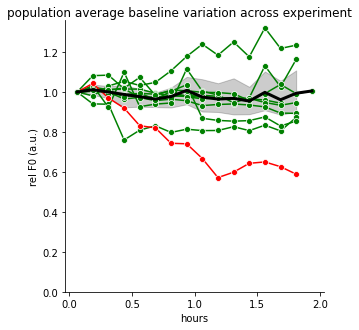

In [9]:
from constants import MAX_F0_REL_DEV
runid_maps = trialagg_stats[Label.RUNID].groupby([Label.DATASET, Label.RUN]).first()

def get_rel_F0(data, F0_key=Label.F0, aggbyrun=True):
    ''' Extract temporal evolution of F0 over experiment '''
    # Figure out dataset ID and associated run order
    dataset_id = data.index.unique(Label.DATASET)[0]
    # Extract frame rate from stats
    fps = get_singleton(trialagg_stats, Label.FPS)
    # Add time along entire experiment to population-average dataframe average
    idx = get_index_along_experiment(data.index, runid_map=runid_maps.loc[dataset_id])
    data[Label.TIME] = idx / fps
    # If specified, aggregate by run
    if aggbyrun:
        data = data.groupby(Label.RUN).median()
    # Compute relative variation from max
    yref = data.sort_values(Label.TIME)[F0_key].iloc[0]
    # yref = data[F0_key].max()
    relF0_key = f'rel {F0_key}'
    data[relF0_key] = data[F0_key] / yref
    # Return data of interest
    return data[[Label.TIME, relF0_key]]

# Compute relative variation of average baseline along experiment, for each dataset
logger.info('inspecting relative variations in baseline fluorescence across experiments...')
aggbyrun = True
F0_key = Label.F0
relF0_key = f'rel {F0_key}'
popagg_F0_per_run = (
    popagg_timeseries
    .groupby(Label.DATASET)
    .apply(lambda x: get_rel_F0(x, F0_key=F0_key, aggbyrun=aggbyrun))
)
popagg_F0_per_run[Label.HOURS] = popagg_F0_per_run[Label.TIME] / 3600

# Compute relative deviations of relative baseline fluorescence from its mean value,
# for each dataset
popagg_relF0_mean = popagg_F0_per_run[relF0_key].groupby(Label.DATASET).mean()
popagg_relF0_reldevs = ((popagg_F0_per_run[relF0_key] - popagg_relF0_mean) / popagg_relF0_mean).abs()

# Identify datasets that have at least 1 large F0 relative deviation from mean
max_popagg_relF0_reldevs = popagg_relF0_reldevs.groupby(Label.DATASET).max()
logger.info(f'maximal relative FO deviations:\n{max_popagg_relF0_reldevs.sort_values()}')
is_relF0_outlier = max_popagg_relF0_reldevs > MAX_F0_REL_DEV

# Extract datasets with at least 1 outlier run
relF0_outliers = is_relF0_outlier[is_relF0_outlier].index.unique(Label.DATASET).values.tolist()

# Remove potential outlier datasets
nouts = len(relF0_outliers)
palette = None
if nouts > 0:
    relF0_outliers_str = '\n'.join([f'  - {x}' for x in relF0_outliers])
    logger.warning(f'identified {nouts} datasets with abnormal baseline fluorescence variations:\n{relF0_outliers_str}')
    trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = exclude_datasets(
        trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, to_exclude=relF0_outliers)
    palette = get_binary_palette(popagg_F0_per_run, relF0_outliers)

# Plot time evolution of average baseline along experiment, for each dataset
pltkwargs = dict(
    x=Label.HOURS,
    y=relF0_key,
)
fg = sns.relplot(
    kind='line',
    data=popagg_F0_per_run,
    errorbar=None, 
    hue=Label.DATASET,
    marker='o',
    palette=palette,
    legend=palette is None,
    aspect=1.,
    height=3 if not aggbyrun else 4.5,
    col=Label.DATASET if not aggbyrun else None,
    col_wrap=4 if not aggbyrun else None,
    **pltkwargs,
)
sns.despine(fig=fg.figure)
figs['popavg F0 across experiment'] = fg.figure
fg.figure.suptitle('population average baseline variation across experiment', y=1.01)
for ax in fg.figure.axes:
    # ax.axhline(1 - MAX_F0_REL_VAR, ls='--', c='k')
    ax.set_ylim(0, ax.get_ylim()[1])
if aggbyrun:
    # Add average trace across valid datasets
    sns.lineplot(
        ax=ax,
        data=popagg_F0_per_run.drop(relF0_outliers),
        lw=3, color='k', legend=False, **pltkwargs
    )

### Inspect run presentation order per dataset and potential consequences on evoked activity

 2023/10/27 14:01:02: plotting I_SPTA (W/cm2) run sequence dependency across dataset...
 2023/10/27 14:01:02: run ID not part of (P (MPa), DC (%)) -> no filtering
 2023/10/27 14:01:02: sub-indexing data...
 2023/10/27 14:01:02: filtering data...
 2023/10/27 14:01:02: cross-checking filters...
 2023/10/27 14:01:02: grouping by dataset, averaging and plotting mean I_SPTA (W/cm2) vs. run ID ...
 2023/10/27 14:01:02: plotting evoked ΔF/F0 change run sequence dependency across dataset...
 2023/10/27 14:01:02: run ID not part of (P (MPa), DC (%)) -> no filtering
 2023/10/27 14:01:02: sub-indexing data...
 2023/10/27 14:01:02: filtering data...
 2023/10/27 14:01:02: cross-checking filters...
 2023/10/27 14:01:02: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. run ID ...
 2023/10/27 14:01:02: plotting evoked Z(ΔF/F0) change run sequence dependency across dataset...
 2023/10/27 14:01:02: run ID not part of (P (MPa), DC (%)) -> no filtering
 2023/10/27 14:01:02: sub-ind

dataset,20190606_mouse2_region1,20190606_mouse2_region2,20190629_mouse2_region1,20190630_mouse3_region1,20190702_mouse1_region1,20190702_mouse5_region1,20190703_mouse4_region1,20190821_mouse6_region1,20190821_mouse7_region1
run ID,,,,,,,,,
0,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_40%DC,0.80MPa_50%DC,0.80MPa_50%DC
1,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_30%DC,NaN,0.80MPa_40%DC
2,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_20%DC,0.80MPa_40%DC,0.80MPa_30%DC
3,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_10%DC,0.80MPa_30%DC,0.80MPa_20%DC
4,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_05%DC,0.80MPa_20%DC,0.80MPa_10%DC
5,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.00MPa_50%DC,0.80MPa_10%DC,0.80MPa_05%DC
6,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.60MPa_50%DC,0.80MPa_05%DC,0.60MPa_50%DC
7,0.60MPa_50%DC,NaN,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.40MPa_50%DC,0.80MPa_60%DC,0.40MPa_50%DC
8,0.40MPa_50%DC,NaN,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.20MPa_50%DC,0.80MPa_70%DC,0.20MPa_50%DC


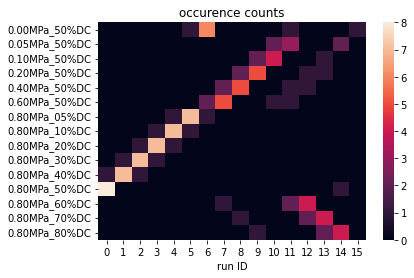

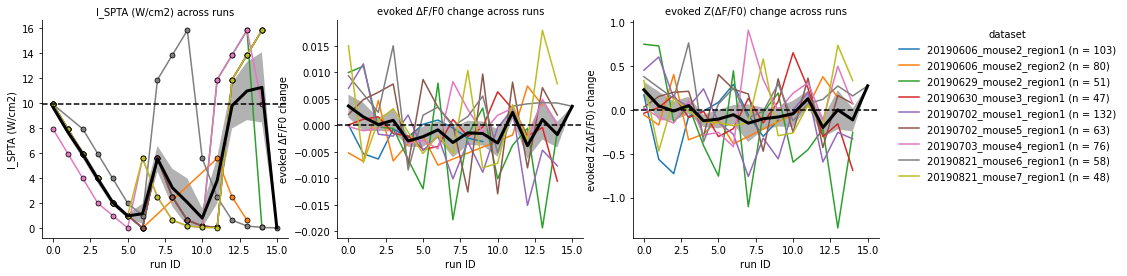

In [10]:
# Get parameter run sequence per dataset
param_seqs = trialagg_stats[[Label.RUNID, Label.P, Label.DC]].groupby([Label.DATASET, Label.RUNID]).first()
param_seqs = get_param_code(param_seqs).unstack().T

# Plot heatmap of occurence count across conditions and run IDs
params_counts = (param_seqs
    .apply(pd.Series.value_counts, axis=1)
    .fillna(0)
    .astype(int)
    .transpose()
)
figs['param count heatmap'], ax = plt.subplots()
ax.set_title('occurence counts')
sns.heatmap(data=params_counts, ax=ax)

# Plot Ispta and evoked DFF across run sequences, per dataset
ykeys_seq = [Label.ISPTA, get_change_key(Label.DFF), get_change_key(Label.ZSCORE)]
Ispta_ref = pressure_to_intensity(P_REF / PA_TO_MPA) / M2_TO_CM2 * DC_REF / 1e2
figs['rundeps_global'], axes = plt.subplots(1, len(ykeys_seq), figsize=(5 * len(ykeys_seq), 4))
for i, (ykey, ax) in enumerate(zip(ykeys_seq, np.atleast_1d(axes))):
    # Plot run sequence dependencies across datasets
    logger.info(f'plotting {ykey} run sequence dependency across dataset...')
    plot_parameter_dependency(
        trialagg_stats, 
        xkey=Label.RUNID, 
        ykey=ykey,
        yref=Ispta_ref if ykey == Label.ISPTA else 0., 
        hue=Label.DATASET, 
        errorbar=None, 
        avgprop='whue', 
        errprop='inter',
        ax=ax, 
        legend=i == len(ykeys_seq) - 1, 
        title=f'{ykey} across runs',
        marker='o' if ykey == Label.ISPTA else None,
    )

logger.info('parameter sequences across datasets:')
param_seqs

### Inspect initial parameter dependency curves

 2023/10/27 14:01:05: sub-indexing data...
 2023/10/27 14:01:05: filtering data...
 2023/10/27 14:01:05: cross-checking filters...
 2023/10/27 14:01:05: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 2023/10/27 14:01:05: sub-indexing data...
 2023/10/27 14:01:05: filtering data...
 2023/10/27 14:01:05: cross-checking filters...
 2023/10/27 14:01:05: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. DC (%) ...
 2023/10/27 14:01:05: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 2023/10/27 14:01:05: sub-indexing data...
 2023/10/27 14:01:05: filtering data...
 2023/10/27 14:01:05: cross-checking filters...
 2023/10/27 14:01:05: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. I_SPTA (W/cm2) ...
 2023/10/27 14:01:05: adding sample counts per dataset on legend labels...
 2023/10/27 14:01:05: sub-indexing data...
 2023/10/27 14:01:05: filtering data...
 2023/10/27 14:01:05: cross-checking fi

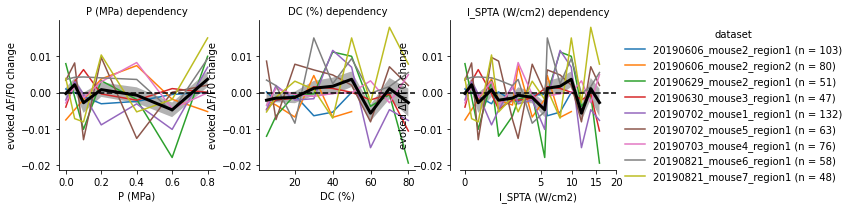

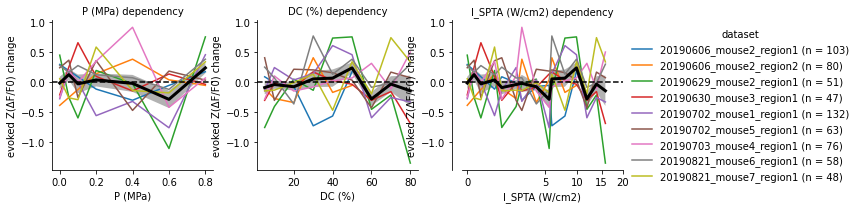

In [11]:
for ykey in [Label.DFF, Label.ZSCORE]:
    ykey_diff = get_change_key(ykey)
    figs[f'stimparamdeps {ykey_diff} initial'] = plot_stimparams_dependency(
        trialagg_stats.copy(),
        xkeys=xkeys_plt,
        ykey=ykey_diff, 
        hue=Label.DATASET,
        avgprop='whue', 
        errorbar=None
    )

In [12]:
# ykey_diff = get_change_key(Label.ZSCORE)
# tmpstats = ext_stats[xkeys_plt + [ykey_diff] + TRIAL_VALIDITY_KEYS]
# for k in ['none'] + [tk for tk in TRIAL_VALIDITY_KEYS if tk in tmpstats.columns]:
#     vstats = tmpstats[~tmpstats[k]] if k != 'none' else tmpstats
#     fig = plot_stimparams_dependency(
#         get_trial_aggregated(vstats, aggfunc=trial_aggfunc),
#         xkeys=xkeys_plt,
#         ykey=ykey_diff, 
#         hue=Label.DATASET,
#         avgprop='whue', 
#         errorbar=None
#     )
#     fig.suptitle(f'{k} trials excluded', y=1.01)

### Inpect parameter dependency curves only for "complete" datasets 

In [13]:
# # Compute number of runs per dataset
# nruns_per_dataset = trialagg_stats.groupby([Label.DATASET, Label.RUN]).first().groupby(Label.DATASET).count().iloc[:, 0]

# # Identify datasets with less than 80% of maximal number of runs
# is_complete_dataset = nruns_per_dataset >= .8 * nruns_per_dataset.max()
# incomplete_datasets = nruns_per_dataset[~is_complete_dataset].index.values.tolist()
# if len(incomplete_datasets) > 0:
#     logger.warning(
#         f'identified {len(incomplete_datasets)} datasets with less than 80% of maximal number of runs:\n{pprint.pformat(incomplete_datasets)}')

#     # Exclude outlier datasets
#     trialagg_stats_complete = exclude_datasets(trialagg_stats, to_exclude=incomplete_datasets)
    
#     for ykey in [Label.DFF, Label.ZSCORE]:
#         ykey_diff = get_change_key(ykey)
#         figs[f'stimparamdeps {ykey_diff} complete'] = plot_stimparams_dependency(
#             trialagg_stats_complete.copy(),
#             xkeys=xkeys_plt,
#             ykey=ykey_diff, 
#             hue=Label.DATASET,
#             avgprop='whue', 
#             errorbar=None
#         )

### Comparison across layers (if applicable)

In [14]:
dataset_ids = trialagg_stats.index.unique(Label.DATASET)
layers = pd.Series(
    [{True: 'layer5', False: 'layer2/3'}[s.endswith('layer5')] for s in dataset_ids],
    index=dataset_ids,
    name=Label.LAYER
)
logger.info(f'datasets count by layer:\n{layers.value_counts()}')
if len(layers.value_counts()) > 1:
    import matplotlib.colors as mcolors
    layer_palette = layers.map(
        dict(zip(layers.unique(), mcolors.TABLEAU_COLORS.keys()))).to_dict()
    trialagg_stats[Label.LAYER] = free_expand(layers, trialagg_stats)
    fig = plot_stimparams_dependency(
        trialagg_stats.copy(),
        xkeys=xkeys_plt,
        ykey=ykey_diff, 
        hue=Label.DATASET,
        hue_alpha=.5,
        palette=layer_palette,
        errorbar=None
    )

    plot_stimparams_dependency(
        trialagg_stats.copy(),
        xkeys=xkeys_plt,
        ykey=ykey_diff, 
        hue=Label.LAYER,
        palette=layer_palette,
        axes=np.array(fig.axes),
        lw=10,
        errorbar=None
    )

 2023/10/27 14:01:11: datasets count by layer:
layer
layer2/3    9
Name: count, dtype: int64


### Inspect dependency of response on stimulation parameters

In [15]:
# ykey_diff = get_change_key(Label.ZSCORE)

# # Compute population-average stats
# popagg_stats = get_popavg_data(ext_stats)

# # Assess response dependency on each parameter
# logger.info('assessing response dependency on stimulation parameters with ANOVA ...')
# for xk in [Label.P, Label.DC]:
#     pval = compute_1way_anova(
#         get_xdep_data(popagg_stats.reset_index(), xk), xk, ykey_diff)
#     logger.info(f'p-value for {xk} dependency: {pval:.3f}')

# # Assess response parameter dependency per dataset with ANOVA
# logger.info('assessing response parameter dependency per dataset with ANOVA...')
# anovares = (
#     popagg_stats[ykey_diff]
#     .groupby(Label.DATASET)
#     .agg(lambda s: compute_1way_anova(s.reset_index(), Label.RUN, ykey_diff))
#     .rename('pval')
#     .to_frame()
# )
# anovares['sig'] = anovares['pval'] < PTHR_DETECTION
# anovares

# # Identify datasets with no parameter dependency
# nonpdeps_datasets = anovares[~anovares['sig']].index.values.tolist()
# if len(nonpdeps_datasets) > 0:
#     logger.warning(f'datasets with no parameter dependency:\n{pprint.pformat(nonpdeps_datasets)}')

# # Create figure backbone
# figs['pdep anova analysis'], axes = plt.subplots(1, 2, figsize=(8, 4))
# for ax in axes:
#     sns.despine(ax=ax)

# # Plot p-value distributions
# sns.histplot(
#     ax=axes[0],
#     data=anovares,
#     x='pval',
#     binwidth=.05,
#     hue='sig',
#     palette={True: 'g', False: 'r'}
# )
# axes[0].set_xlim(0, 1)

# # Plot parameter dependencies per dataset, along with ANOVA result color code
# sns.lineplot(
#     ax=axes[1],
#     data=popagg_stats,
#     x=Label.RUN,
#     y=ykey_diff,
#     hue=Label.DATASET,
#     palette=get_binary_palette(anovares, nonpdeps_datasets),
#     errorbar=None,
#     legend=False
# )
# axes[1].axhline(0, ls='--', c='k')

## Curations & corrections

### Inspect & correct response stationarity throughout trial sequences

 2023/10/27 14:01:14: computing population average data across (dataset, run, trial)...
 2023/10/27 14:01:14: ignoring object-typed columns ['response type'] in population average data
 2023/10/27 14:01:14: comparing evoked Z(ΔF/F0) change values in across half sequences...


0it [00:00, ?it/s]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 1.00e-01
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

9_1 vs. 9_2: Mann-Whitney-Wilcoxon test two-sided, P_val:7.202e-02 U_stat=2.426e+03
10_1 vs. 10_2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.565e-01 U_stat=1.324e+03
11_1 vs. 11_2: Mann-Whitney-Wilcoxon test two-sided, P_val:5.626e-01 U_stat=2.170e+03
12_1 vs. 12_2: Mann-Whitney-Wilcoxon test two-sided, P_val:9.829e-01 U_stat=2.053e+03
13_1 vs. 13_2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.147e-02 U_stat=1.517e+03
14_1 vs. 14_2: Mann-Whitney-Wilcoxon test two-sided, P_val:7.170e-02 U_stat=1.878e+03
15_1 vs. 15_2: Mann-Whitney-Wilcoxon test two-sided, P_val:9.591e-01 U_stat=3.300e+01
8_1 vs. 8_2: Mann-Whitney-Wilcoxon test two-sided, P_val:6.559e-01 U_stat=1.954e+03
1_1 vs. 1_2: Mann-Whitney-Wilcoxon test two-sided, P_val:3.112e-01 U_stat=2.261e+03
0_1 vs. 0_2: Mann-Whitney-Wilcoxon test two-sided, 

1it [00:01,  1.12s/it]

7_1 vs. 7_2: Mann-Whitney-Wilcoxon test two-sided, P_val:7.013e-01 U_stat=1.967e+03
 2023/10/27 14:01:17: plotting evoked Z(ΔF/F0) change along trial sequences...


 2023/10/27 14:01:26: computing ROI-weighted average of (9 datasets x 288 ROIs x 15 runs x 16 trials) "evoked Z(ΔF/F0) change" series across run ID & trial...
 2023/10/27 14:01:26: adding regression estimates...
 2023/10/27 14:01:29: assessing evoked Z(ΔF/F0) change stationarity, by run ID, with linear regression analysis
 2023/10/27 14:01:30: identified evoked Z(ΔF/F0) change non-stationarity in the following run ID: [14]


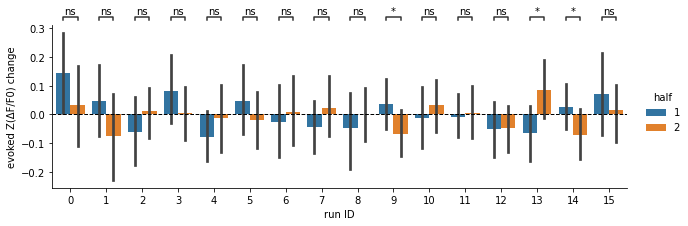

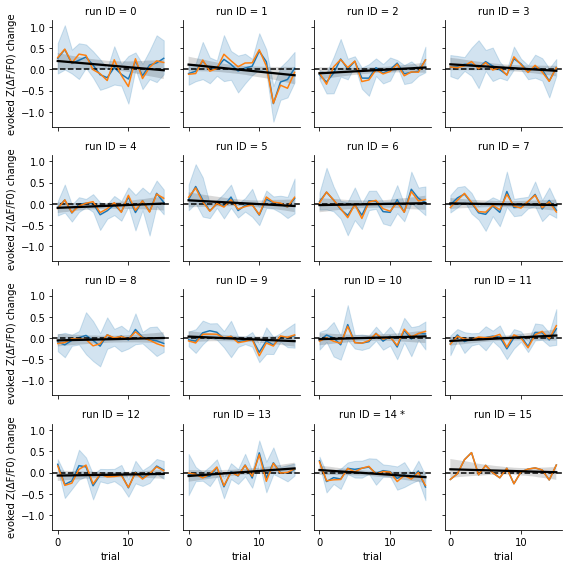

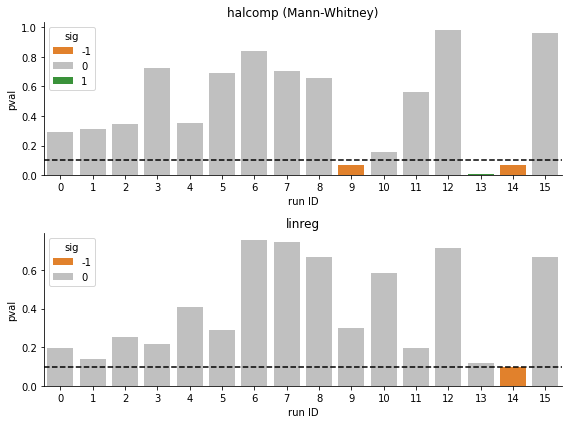

In [16]:
from constants import PTHR_STATIONARITY

# Determine output metrics
ykey_diff = get_change_key(Label.ZSCORE)
stationarity_gby = Label.RUNID  # grouping variable for stationarity analysis

# Compute population-average stats for each trial 
popagg_stats = get_popavg_data(ext_stats)

# Add trial half information
isplit = len(popagg_stats.index.unique(Label.TRIAL)) // 2 - 1
popagg_stats['half'] = popagg_stats.index.get_level_values(Label.TRIAL) <= isplit
popagg_stats['half'] = popagg_stats['half'].map({True: 1, False: 2})

# Evaluate difference between each half distribution statistically
logger.info(f'comparing {ykey_diff} values in across half sequences...')
from scipy.stats import mannwhitneyu, ttest_ind
testtype = 'Mann-Whitney'
# testtype = 't-test_ind'
testfunc = {
    't-test_ind': ttest_ind,
    'Mann-Whitney': mannwhitneyu
}[testtype]
cross_dataset_halfcomp_stats = (
    popagg_stats
    .groupby(stationarity_gby)
    .apply(lambda df: compare_halves(df, ykey_diff, testfunc))
    .assign(sig=lambda df: assess_significance(df, PTHR_STATIONARITY, sign_key='diff'))
)

# Plot halves comparison results
pltkwargs = dict(
    data=popagg_stats.reset_index(),
    x=stationarity_gby,
    y=ykey_diff,
    hue='half',
)
fg = sns.catplot(
    kind='bar',
    aspect=3,
    height=3,
    **pltkwargs)
fg.refline(y=0, c='k', lw=1)
annotate_facets(fg, test=testtype, alpha=PTHR_STATIONARITY, **pltkwargs)

# Plot response strength over trial sequence, by grouping variable, 
# with superimposed linear regression estimate
logger.info(f'plotting {ykey_diff} along trial sequences...')
trialseq_fgkwargs = dict(
    x=Label.TRIAL,
    y=ykey_diff,
    col_wrap=4,
    height=2.,
    legend='full'
)
fg = sns.relplot(
    kind='line',
    data=popagg_stats,
    col=stationarity_gby,
    **trialseq_fgkwargs
)
fg.refline(y=0, c='k')
weighted_popagg_stats = get_crossdataset_average(
    ext_stats, [stationarity_gby, Label.TRIAL], ykey=ykey_diff)
for ax, (_, gdata) in zip(fg.axes, weighted_popagg_stats.groupby(stationarity_gby)):
    ax.plot(gdata.index.get_level_values(Label.TRIAL), gdata[f'{ykey_diff} - mean'], c='C1')
logger.info('adding regression estimates...')
fg.map_dataframe(
    sns.regplot, 
    scatter=False, 
    color='k', 
    x=Label.TRIAL, 
    y=ykey_diff,
)
figs[f'{ykey_diff} stationarity along trial seq'] = fg.figure

# Perform linear regression on lumped data, by grouping variable, to assess response stationarity
logger.info(f'assessing {ykey_diff} stationarity, by {stationarity_gby}, with linear regression analysis')
cross_dataset_linreg_stats = (popagg_stats
    .groupby(stationarity_gby)
    [ykey_diff]
    .apply(apply_linregress)
    .unstack()
    .assign(sig=lambda df: assess_significance(df, PTHR_STATIONARITY, sign_key='slope'))
)

# Plot stationarity p-value for each group
stationarity_measures = {
    f'halcomp ({testtype})': cross_dataset_halfcomp_stats,
    'linreg': cross_dataset_linreg_stats
}
figs[f'{ykey_diff} stationarity p-value by {stationarity_gby}'], axes = plt.subplots(2, 1, figsize=(8, 6))
for ax, (k, resdata) in zip(axes, stationarity_measures.items()):
    sns.despine(ax=ax)
    sns.barplot(
        ax=ax,
        data=resdata.reset_index(),
        x=stationarity_gby,
        y='pval',
        hue='sig',
        palette=Palette.TERNARY,
        dodge=False,
    )
    ax.set_title(k)
    ax.axhline(PTHR_STATIONARITY, ls='--', c='k')
figs[f'{ykey_diff} stationarity p-value by {stationarity_gby}'].tight_layout()

# Identify and mark groups with non-stationarity in response strength
non_stationary_groups = cross_dataset_linreg_stats[cross_dataset_linreg_stats['sig'] != 0].index.values
if len(non_stationary_groups) > 0:
    logger.warning(f'identified {ykey_diff} non-stationarity in the following {stationarity_gby}: {non_stationary_groups}')
    for k in non_stationary_groups:
        fg.axes_dict[k].set_title(f'{fg.axes_dict[k].get_title()} *', fontsize=10)
else:
    logger.info(f'no significant {ykey_diff} non-stationarity identified')


# Trick: restrict non-stationary groups to first zero
if stationarity_gby == Label.RUNID:
    non_stationary_groups = list(set(non_stationary_groups).intersection([0]))

# For each non-stationary group
if do_nonstat_correct and len(non_stationary_groups) > 0:
    for group_id in non_stationary_groups:

        # Extract detailed stats for that group
        logger.info(f'extracting detailed stats for {stationarity_gby} {group_id}...')
        if stationarity_gby in ext_stats.index.names:
            detailed_stats_group = ext_stats[ext_stats.index.get_level_values(stationarity_gby) == group_id]
        else:
            detailed_stats_group = ext_stats[ext_stats[stationarity_gby] == group_id]

        # Extract last trial index for each ROI
        logger.info('extracting last trial index for each ROI...')
        last_trial_idx = (detailed_stats_group.iloc[:, 0]
            .groupby([Label.DATASET, Label.ROI, Label.RUN])
            .agg(lambda s: s.index[-1][-1])
        )

        # Perform independent linear regression for each ROI, over trial sequence
        logger.info(f'performing {ykey_diff} linear regression independently on each ROI...')
        linreg_stats_per_roi = (detailed_stats_group[ykey_diff]
            .groupby([Label.DATASET, Label.ROI, Label.RUN])
            .apply(apply_linregress)
            .unstack()
        )

        # Compute project response at last trial from linear regression results
        logger.info(f'projecting {ykey_diff} values from linear regression results...')
        ydiff_proj = linreg_stats_per_roi['slope'] * last_trial_idx + linreg_stats_per_roi['intercept']

        # Compute ratios between trial-aggregated and projected responses
        logger.info(f'computing ratios between trialagg {ykey_diff} values and their lin-reg projected values...')
        ratios = ydiff_proj / trialagg_stats.loc[ydiff_proj.index, ykey_diff]

        # Replace trial-aggregated response values by projected responses values 
        logger.info(f'replacing trialagg {ykey_diff} values by their lin-reg projected values...')
        trialagg_stats.loc[ydiff_proj.index, ykey_diff] = ydiff_proj

        # Use computed ratios to rescale z-scores as well
        zkey_diff = get_change_key(Label.ZSCORE)
        logger.info(f're-scaling trialagg {zkey_diff} values according to {ykey_diff} ratios...')
        trialagg_stats.loc[ydiff_proj.index, zkey_diff] *= ratios
    
        # Re-assess responses
        zthr = pvalue_to_zscore(PTHR_DETECTION, directional=directional)
        trialagg_stats[Label.RESP_TYPE] = zscore_to_resp_type(
            trialagg_stats[get_change_key(Label.ZSCORE)], zthr, directional=directional)
    
    # Re-classify responders
    roistats = classify_ROIs(trialagg_stats)
    for k in roistats:
        trialagg_stats[k] = roistats[k]

    # Re-plot parameter dependency curves
    for ykey_diff in [get_change_key(Label.DFF), get_change_key(Label.ZSCORE)]:
        figs[f'{ykey_diff} stimparamdeps post global stationary correct'] = plot_stimparams_dependency(
            trialagg_stats.copy(),
            xkeys=xkeys_plt,
            ykey=ykey_diff, 
            hue=Label.DATASET,
            avgprop='whue',
            errorbar=None,
        )
    
    do_nonstat_correct = False

## Results visualization

### Plot evoked change distribution for control condition (P = 0)

 2023/10/27 14:01:34: response type proportions at P = 0:
response type
weak        91.793313
positive     8.206687
Name: count, dtype: float64


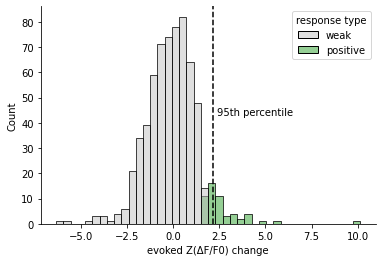

In [17]:
trialagg_stats0 = trialagg_stats[trialagg_stats[Label.P] == 0]
ykeydiff = get_change_key(Label.ZSCORE)

# Plot distribution of evoked response for baseline condition with response class color code
figs[f'{ykey_diff} dist baseline'], ax = plt.subplots()
sns.despine(ax=ax)
sns.histplot(
    ax=ax,
    data=trialagg_stats0,
    x=ykeydiff,
    hue=Label.RESP_TYPE,
    hue_order=get_default_rtypes(),
    palette=Palette.RTYPE
)
# Add 95th percentile location
q95 = trialagg_stats0[ykeydiff].quantile(.95)
ax.axvline(q95, c='k', ls='--')
ax.text(1.1 * q95, 0.5 * ax.get_ylim()[1], '95th percentile')

# Log responder fraction information
props0 = trialagg_stats0[Label.RESP_TYPE].value_counts() / len(trialagg_stats0) * 100
logger.info(f'response type proportions at P = 0:\n{props0}')

### Extract dictionary of fits per input parameters for current mouse line 

In [18]:
fit_dict = get_fit_table()[mouseline]
logger.info(f'fit_dict:\n{fit_dict}')

 2023/10/27 14:01:36: fit_dict:
parameter
P (MPa)             None
DC (%)              None
P_SPTA (MPa)        None
P_SPTRMS (MPa)      None
I_SPTA (W/cm2)      None
I_SPTRMS (W/cm2)    None
Name: pv, dtype: object


### Plot parameter dependency curves, with fits

 2023/10/27 14:01:37: plotting ['evoked ΔF/F0 change', 'evoked Z(ΔF/F0) change', 'responder fraction'] stimulation parameters dependencies...
 2023/10/27 14:01:37: sub-indexing data...
 2023/10/27 14:01:37: filtering data...
 2023/10/27 14:01:37: cross-checking filters...
 2023/10/27 14:01:37: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 2023/10/27 14:01:37: sub-indexing data...
 2023/10/27 14:01:37: filtering data...
 2023/10/27 14:01:37: cross-checking filters...
 2023/10/27 14:01:37: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. DC (%) ...
 2023/10/27 14:01:37: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 2023/10/27 14:01:37: sub-indexing data...
 2023/10/27 14:01:37: filtering data...
 2023/10/27 14:01:37: cross-checking filters...
 2023/10/27 14:01:37: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. I_SPTA (W/cm2) ...
 2023/10/27 14:01:38: plotting ['evoked ΔF/F0 change', 

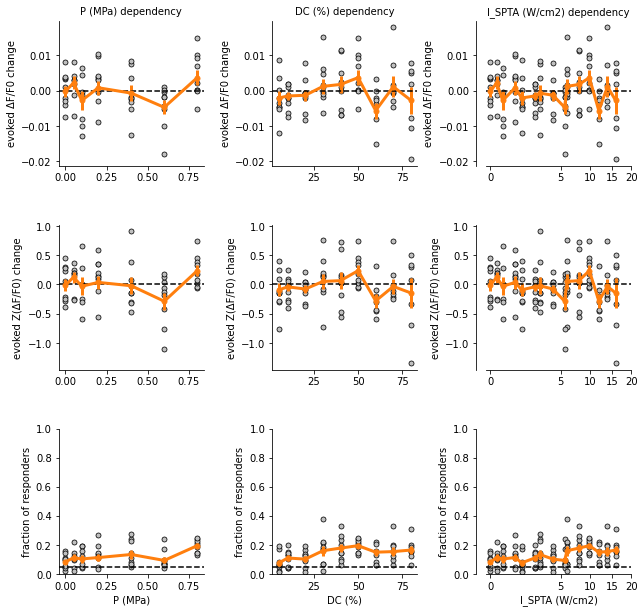

In [19]:
ykeys_resp = [get_change_key(k) for k in ykeys_plt] + [Label.RESP_FRAC]
figs['stimparamdeps post curation'] = plot_stimparams_dependency(
    trialagg_stats, 
    ykeys_resp,
    xkeys=xkeys_plt,  
    hue=Label.DATASET,
    palette='uniform',
    avgprop='whue', 
    avg_color='line',
    avgmarker='o',
    marker='o', 
    lw=0,
    errorbar=None,
    err_style='bars',
    fit=fit_dict,
    fit_ci=.67,
)

# Optional: set symlog y-axis scales on plots for output variables exceeding criticial value
ycrit = 3.
axes = np.reshape(figs['stimparamdeps post curation'].axes, (len(ykeys_resp), -1))
for axrow, k in zip(axes, ykeys_resp):
    if k in trialagg_stats and trialagg_stats[k].groupby([Label.RUN, Label.DATASET]).mean().max() > ycrit:
        for ax in axrow:
            ax.set_yscale('symlog')

### Plot P - DC alignment for various dose projections

 2023/10/27 14:01:41: computing ROI-weighted average of (9 datasets x 288 ROIs x 15 runs) "evoked Z(ΔF/F0) change" series across run...


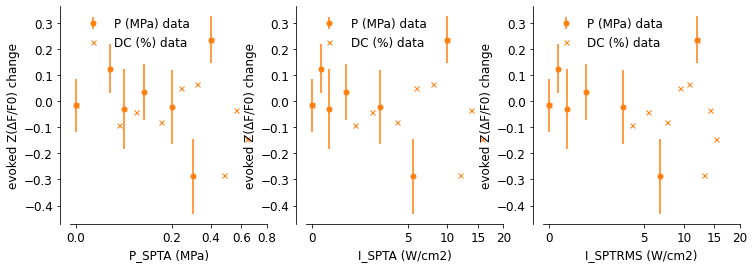

In [20]:
# Dose metrics
xkeys = [
    Label.PSPTA,
    Label.ISPTA,
    Label.ISPTRMS,
]

# Dependent response variable
ykey_diff = get_change_key(Label.ZSCORE)

# Evaluate and plot alignment between DC sweep sigmoid predictor 
# and P sweep data
fig = plot_response_alignment(
    trialagg_stats,
    xkeys, 
    ykey_diff,
    fit_dict, 
    xscale='sqrt', 
    height=4,
)

### Plot response traces

 2023/10/27 14:01:43: adding ['fps' 'duration (s)' 'P (MPa)' 'DC (%)'] information to timeseries...
 2023/10/27 14:01:44: adding time info to table...
 2023/10/27 14:01:44: sub-indexing data...
 2023/10/27 14:01:44: filtering data...
 2023/10/27 14:01:44: cross-checking filters...
 2023/10/27 14:01:44: grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 2023/10/27 14:01:46: sub-indexing data...
 2023/10/27 14:01:46: filtering data...
 2023/10/27 14:01:46: cross-checking filters...
 2023/10/27 14:01:46: grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...
 2023/10/27 14:01:47: sub-indexing data...
 2023/10/27 14:01:47: filtering data...
 2023/10/27 14:01:48: cross-checking filters...
 2023/10/27 14:01:48: grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 2023/10/27 14:01:49: sub-indexing data...
 2023/10/27 14:01:49: filtering data...
 2023/10/27 14:01:49: cross-checking filters...
 2023/10/27 14:01:49: grouping by DC (%),

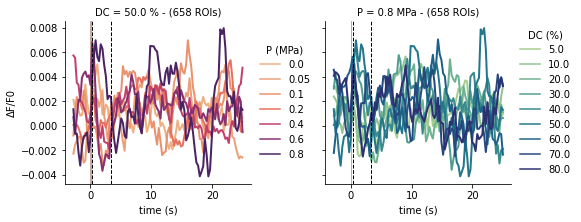

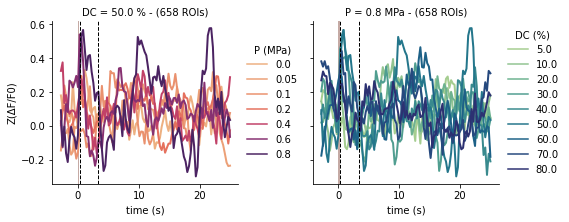

In [21]:
%%skip $skip_traces

# Determine input parameters
pkeys = [Label.P, Label.DC]

# Determine whether to group by responder type or not
groupby = None #Label.ROI_RESP_TYPE

# Determine which stats columns to merge with traces
mergecols = [Label.FPS, Label.DUR] + pkeys.copy()
if groupby is not None:
    mergecols.append(groupby)

# Get plot-ready traces dataset
plt_data = get_plot_data(trialagg_timeseries, trialagg_stats[mergecols])

# # Align DFF and z-score traces w.r.t their pre-stimulus average
# plt_data.loc[:, [Label.DFF, Label.ZSCORE]] = align_at(
#     plt_data[[Label.DFF, Label.ZSCORE]], FrameIndex.PRESTIM)

# For each output variable
for ykey in ykeys_plt:

    # # Pressure-dependent and duty cycle dependent response traces, per dataset
    # for pkey in pkeys:
    #     figs.update(
    #         plot_responses_across_datasets(
    #             plt_data, ykey=ykey, pkey=pkey, groupby=groupby))

    # Global (weighted) response curves for both input stimulation parameters
    avgaxes = []
    if groupby is None:
        figs[f'{ykey} resp traces'], axes = plt.subplots(
            1, len(pkeys), figsize=(4 * len(pkeys), 3), 
            sharey=True, gridspec_kw=dict(wspace=.4))
    else:
        axes = [None] * len(pkeys)
    for pkey, ax in zip(pkeys, axes):
        fig = plot_responses_across_datasets(
            plt_data, ykey=ykey, pkey=pkey, ax=ax, avg=True, groupby=groupby)
        if ax is not None:
            sns.move_legend(
                ax, 'center left', bbox_to_anchor=(1, 0.5), frameon=False)
        else:
            if isinstance(fig, dict):
                figs.update(fig)
            else:
                figs[f'{ykey} resp traces vs. {pkey}'] = fig
                avgaxes += fig.axes
    if len(avgaxes) > 0:
        harmonize_axes_limits(avgaxes, axkey='y')

### Evaluate impact of exclusion criteria

 2023/10/27 14:01:53: computing ΔF/F and z-score traces median values for each ROI & run...
 2023/10/27 14:01:53: plotting % of excluded samples per dataset, across criteria
 2023/10/27 14:01:53: adding time info to table...
 2023/10/27 14:01:53: identifying conditions with >= 5 valid trials
 2023/10/27 14:01:53: adding expanded validity index to timeseries ...
 2023/10/27 14:01:54: filtering timeseries ...
 2023/10/27 14:01:54: identified 125/2000 (6.2%) samples with "discarded" tag
 2023/10/27 14:01:54: identifying conditions with >= 5 valid trials
 2023/10/27 14:01:54: adding expanded validity index to timeseries ...
 2023/10/27 14:01:54: filtering timeseries ...
 2023/10/27 14:01:55: identified 16/2000 (0.8%) samples with "motion" tag
 2023/10/27 14:01:55: identifying conditions with >= 5 valid trials
 2023/10/27 14:01:55: adding expanded validity index to timeseries ...
 2023/10/27 14:01:55: filtering timeseries ...
 2023/10/27 14:01:55: identified 0/2000 (0.0%) samples with "pre-

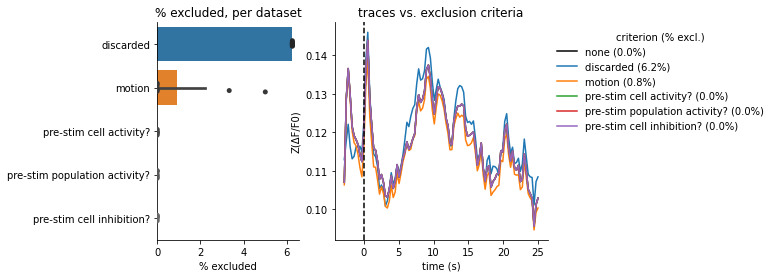

In [22]:
# Copy traces dataset
df = popagg_timeseries.copy()

# Offset traces by their median values
logger.info('computing ΔF/F and z-score traces median values for each ROI & run...')
ykeys_offset = [Label.DFF, Label.ZSCORE]
ymeds = df[ykeys_offset].groupby([Label.DATASET, Label.RUN]).median()
df[ykeys_offset] -= expand_to_match(ymeds, df.index)

# Plot pct of exclusion per criterion and traces vs exclusion criteria
figs['impact of exclusion criteria'], axes = plt.subplots(
    1, 2, figsize=(7, 4), width_ratios=[1, 1.5])
plot_pct_excluded(ext_stats, ax=axes[0])
plot_traces_vs_exclusion(df, popagg_stats, ykey, ax=axes[1]);

### Inspect state-dependency of evoked responses

In [24]:
# # Determine variable of interest
# ykey = Label.ZSCORE

# # Determine color based on mouse line
# color = Palette.LINE[get_singleton(ext_stats, Label.LINE)]

# # Determine whethere to use population-average data or not
# use_popavg = False

# # Define whether to use change or post-stimulus average
# use_change = True

# # Determine whether to add linear regression
# addreg = False

# # If pop-avg data is to be used 
# if use_popavg:
#     # Shuffle population-average data, per dataset and condition
#     shuffled_popagg_timeseries = (popagg_timeseries
#         .groupby([Label.DATASET, Label.RUN])
#         .transform(shuffle)
#     )

#     # Compute pre-stim and post-stim averages as well as stim evoked change, for both
#     # original and shuffled pop-average data
#     prepost_stats = pd.concat([
#         compute_evoked_change(
#             popagg_timeseries, ykey, full_output=True),
#         compute_evoked_change(
#             shuffled_popagg_timeseries, ykey, full_output=True).add_prefix('shuffled '), 
#         ], axis=1)
#     # Add ISPTA information
#     prepost_stats[Label.ISPTA] = popagg_stats[Label.ISPTA]

# # Otherwise, use provided stats
# else:
#     prepost_stats = ext_stats

# # For both original and shuffled data
# tmpaxes = []
# for prefix in ['', 'shuffled ']:
#     # Plot pre-post distribution and associated statistics
#     figs[f'prepost corr{prefix}'] = plot_prepost_correlation(
#         prepost_stats, 
#         ykey, 
#         use_change=use_change,
#         splitby=Label.ISPTA,
#         addreg=addreg,
#         color='silver' if prefix else color,
#         prefix=prefix,
#     )
#     figs[f'prepost corr{prefix}'].suptitle(
#         f'pre-post {ykey} distributions ({prefix if prefix else "original "}data)', y=1.02)
#     # Add axes to list
#     tmpaxes = tmpaxes + figs[f'prepost corr{prefix}'].axes

# # Harmonize axes limits
# harmonize_axes_limits(tmpaxes, axkey='xy')

In [25]:
# # Extract keys
# y_prestim_avg, y_poststim_avg, y_change = get_change_key(ykey, full_output=True)
# xykeys = [
#     y_prestim_avg, 
#     y_change if use_change else y_poststim_avg
# ]

# # Determine grouping categories
# gby = [
#     Label.ISPTA, 
#     Label.DATASET,
#     # Label.ROI,
# ]

# # For original and shuffled data
# statedep_data = {}
# for prefix in ['', 'shuffled ']:
#     # Extract keys for pre-stimulus average and change
#     xykeys = [f'{prefix}{y}' for y in [y_prestim_avg, y_change]]

#     # Compute Pearson correlation coefficient between pre-stimulus average and change
#     logger.info(f'computing correlation coefficients between {xykeys[1]} vs {xykeys[0]}...')
#     corrcoeffs = (prepost_stats
#         .groupby(gby)
#         [xykeys]
#         .corr()
#         .droplevel(-1)
#         .iloc[::2, 1]
#         .rename('R')
#     )
#     tmpdata = corrcoeffs.to_frame()

#     # Compute linear regression on pre-stimulus average and change
#     if addreg:
#         logger.info(f'computing linear regression on {y_prestim_avg} and {y_change}...')
#         regres = (prepost_stats
#             .groupby(gby)
#             [xykeys]
#             .apply(lambda df: apply_linregress(
#                 df, xkey=xykeys[0], ykey=xykeys[1], robust=True))
#         )
#         tmpdata = pd.concat([tmpdata, regres], axis=1)
 
#     # Add to output dict
#     statedep_data[prefix[:-1] if prefix else 'original'] = tmpdata

# # Assemble single state-dep stats dataframe and save to file
# statedep_data = pd.concat(statedep_data, names=['kind'])
# savefpath = os.path.join(
#     split_path_at(get_data_root(), 'raw')[0], 
#     f'statedep_data_{mouseline}.csv')
# statedep_data.to_csv(savefpath)

# # Create figure
# outkeys = ['R']
# if addreg:
#     outkeys.append('slope')
# fig, axes = plt.subplots(len(outkeys), 2, figsize=(6, 3 * len(outkeys)))
# axes = np.atleast_2d(axes)

# # Plot results
# logger.info('plotting results...')
# for (ax, k) in zip(axes[:, 0], outkeys):
#     sns.despine(ax=ax)
#     sns.lineplot(
#         ax=ax,
#         data=statedep_data,
#         x=Label.ISPTA,
#         y=k,
#         errorbar='se',
#         style='kind',
#         color=color,
#         lw=2,
#     )
#     ax.legend(frameon=False)

# for (ax, k) in zip(axes[:, 1], outkeys):
#     sns.despine(ax=ax)
#     pltkwargs = dict(
#         ax=ax,
#         data=statedep_data.reset_index(),
#         x='kind',
#         y=k,
#         palette={'original': color, 'shuffled': 'silver'},
#     )
#     sns.violinplot(**pltkwargs)

#     # Perform statistical test and annotate plot 
#     annotator = Annotator(
#         pairs=[statedep_data.index.unique('kind').to_list()], **pltkwargs)
#     annotator.configure(test='Mann-Whitney', loc='outside')
#     annotator.apply_and_annotate()

# # Adjust layout and add title
# fig.tight_layout()
# fig.suptitle('state dependent response stats', y=1.01)

# # Add figure to output dict
# figs['prepost stats'] = fig

# # Plot results for original data only with dataset color code
# fig, axes = plt.subplots(1, len(outkeys), figsize=(3 * len(outkeys), 3))
# for (ax, k) in zip(np.atleast_1d(axes), outkeys):
#     sns.despine(ax=ax)
#     for hue in [None, Label.DATASET]:
#         sns.lineplot(
#             ax=ax,
#             data=statedep_data.loc['original'],
#             x=Label.ISPTA,
#             y=k,
#             hue=hue,
#             color=color if hue is None else None,
#             legend=hue is not None and k == outkeys[-1],
#             lw=3 if hue is None else 0,
#             marker='o' if hue is not None else None,
#             markersize=5,
#             errorbar='se' if hue is None else None,
#             zorder=10 if hue is None else 0,
#         )
#     if k == 'R':
#         ax.set_ylim(-1, 0)
# sns.move_legend(ax, 'center left', bbox_to_anchor=(1, .5), ncol=2, frameon=False)
# fig.suptitle('state dependent response strength vs ISPTA', y=1.01)
# figs['prepost vs ISPTA by dataset'] = fig

### ROI breakdown per dataset

 2023/10/24 13:10:02: computing fraction of response occurence per ROI over 9 "strong ISPTA" conditions...
 2023/10/24 13:10:03: identified 6.1% of responders with 0.5 as threshold proportion of responding conditions
 2023/10/24 13:10:03: plotting cell maps...


100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


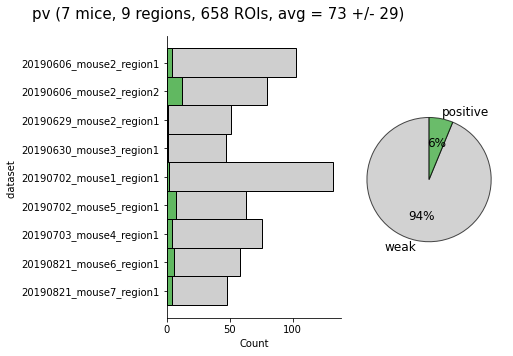

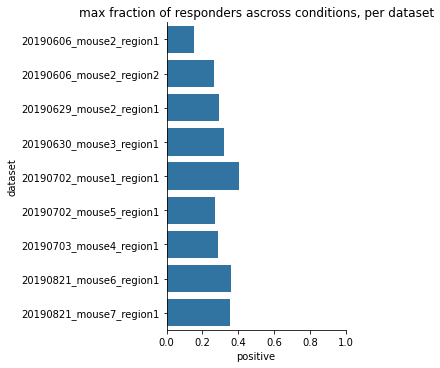

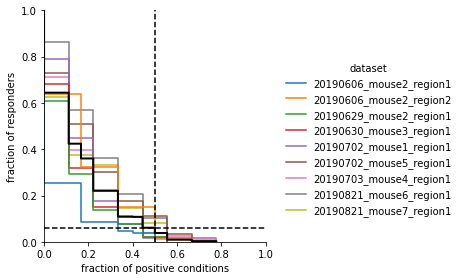

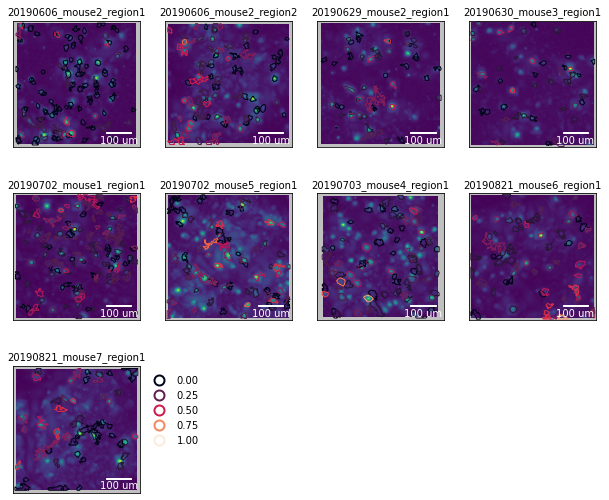

In [26]:
# Plot cell count distribution and breakdown
figs['rtype dist per mousereg'] = plot_cellcounts(
    trialagg_stats, hue=Label.ROI_RESP_TYPE, title=mouseline)

# Plot distribution of max number of responders across conditions 
resp_counts = (
    trialagg_stats[Label.RESP_TYPE]
    .groupby([Label.DATASET, Label.RUN])
    .value_counts().unstack()
)
resp_counts['total'] = resp_counts.sum(axis=1)
resp_props = resp_counts.div(resp_counts['total'], axis=0)
max_pos_props= resp_props['positive'].groupby(Label.DATASET).max()
max_pos_props = max_pos_props.to_frame().reset_index()
fg = sns.catplot(
    data=max_pos_props,
    kind='bar', 
    x='positive', 
    y=Label.DATASET,
    color='C0'
)
fg.figure.axes[0].set_xlim(0, 1)
fg.figure.axes[0].set_title('max fraction of responders ascross conditions, per dataset')
figs['max % resp'] = fg.figure

# Plot cell classification details 
figs['classification details'] = plot_classification_details(
    trialagg_stats, pthr=PROP_CONDS_THR, hue=Label.DATASET)

# Plot cell maps
figs['cellmaps with rtype'] = plot_fields_of_view(
    map_ops, 
    ROI_masks=ROI_masks,
    Fstats=trialagg_stats, 
    refkey='Vcorr', 
    mode='contour', 
    hue='positive'
)

### Plot trial heatmap per condition for entire mouse line

In [27]:
%%skip $skip_rasters

sorted_ISPTAs = trialagg_stats[Label.ISPTA].groupby(Label.RUN).first().sort_values().apply(
    '{:.2f} W/cm2'.format)
fps = get_singleton(trialagg_stats, Label.FPS)

for ykey in ykeys_plt:
    figs[f'{ykey} heatmap'] = plot_activity_heatmap(
        trialagg_timeseries, ykey, fps, col=Label.RUN,
        col_order=sorted_ISPTAs.index.values, 
        col_labels=sorted_ISPTAs.values,
        rasterized=True,
        colwrap=len(sorted_ISPTAs), 
        sort_ROIs=True,
    )

### Plot ROI / neuropil fluorescence ratio

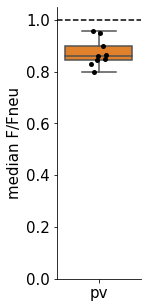

In [28]:
from plotters import plot_fluorescence_ratios
figs['F/Fneu'] = plot_fluorescence_ratios(popagg_timeseries, mouseline)

### Inspect dynamics of population-averaged activity

In [29]:
%%skip $skip_osc_analysis

# Define output metrics
ykey = Label.ZSCORE

# Extract frame rate
fps = get_singleton(trialagg_stats, Label.FPS)

# Add time, trial phase, run ID and ISPTA info to popagg_timeseries
add_time_to_table(popagg_timeseries, fps=fps)
add_trial_phase_to_table(popagg_timeseries)
popagg_params_by_run = popagg_stats.groupby([Label.DATASET, Label.RUN]).first()
popagg_timeseries[Label.RUNID] = popagg_params_by_run[Label.RUNID]
popagg_timeseries[Label.ISPTA] = popagg_params_by_run[Label.ISPTA]#.round(2)

# Extract trial-repetition frequency
ISI = (NFRAMES_PER_TRIAL - 1) / fps  # inter-sonication interval
ftrial = 1 / ISI
logger.info(f'inter-sonication interval = {ISI:.2f} s, i.e. trial repetition frequency = {ftrial:.2f} Hz')

# Extract response window interval
resp_tbounds = (bounds(FrameIndex.RESPONSE) - FrameIndex.STIM) / fps

# Define plotting options
fmax = .35  # upper frequency limit for spectrum graphs

# Define frequency band for neural oscillations of interest
fband_osc = [.05, .2]  # Hz

# Plot timecourses and frequency spectra across runs, for population-average data
ykeys = [ykey]
nrows = popagg_timeseries.groupby(Label.DATASET).ngroups
figs[f'popagg {ykey} metrics'], axes = plt.subplots(
    nrows, 2, figsize=(15, 7 * nrows), 
    gridspec_kw=dict(width_ratios=(1, .2))
)
hue = Label.ISPTA
groups = popagg_timeseries.groupby(Label.DATASET)
logger.info(f'plotting pop-avg profiles and spectra by dataset and {hue}...')
for axrow, (dadaset_id, gdata) in zip(axes, tqdm(groups)):
    mydata = gdata.reset_index(level=Label.DATASET, drop=True)
    plot_popagg_timecourse(
        mydata, ykeys, fps, ax=axrow[0], legend=False, hue=hue, verbose=False)
    plot_popagg_frequency_spectrum(
        mydata, ykeys, fps, fmax=fmax, ax=axrow[1], fband=fband_osc, hue=hue, verbose=False)
    sns.move_legend(axrow[1], 'upper left', bbox_to_anchor=(1, 1), frameon=False)
    axrow[0].set_title(dadaset_id.replace('_', ' '))
figs[f'popagg {ykey} metrics'].subplots_adjust(hspace=0.3)

### Inspect neuronal oscillations in control (P = 0) condition

In [30]:
%%skip $skip_osc_analysis

# Compute frequency spectra for population-average data in control condition
nostim_popagg_spectra = (
    popagg_timeseries.loc[popagg_timeseries[Label.ISPTA] == 0, ykey]
    .groupby(Label.DATASET)
    .apply(lambda s: get_power_spectrum(s, fps, method='welch', normalize=True)) 
)

# Plot log-power spectrum
logger.info('plotting power spectrum for baseline contition')
fscale = 'log'
if fscale == 'log':
    nostim_popagg_spectra = nostim_popagg_spectra[nostim_popagg_spectra[Label.FREQ] > 0]
figs['control_spectrum'], ax = plt.subplots(figsize=(3, 3))
sns.lineplot(
    ax=ax,
    data=nostim_popagg_spectra,
    x=Label.FREQ,
    y=Label.PSPECTRUM_DB,
    errorbar='se',
)
ax.set_title('spectrum for control condition')
ax.axvspan(*fband_osc, fc='silver', ec=None, alpha=.5)
ax.axvline(ftrial, c='k', ls='--')
sns.despine(ax=ax)
ax.set_xscale(fscale)
ax.xaxis.set_major_formatter(ScalarFormatter())

### Inpsect parameter dependency of amplitude of neural oscillations

In [31]:
%%skip $skip_osc_analysis

# Determine relevant input parameter
stimkey = Label.ISPTA

# Add inter-trial interval index to popagg timeseries
add_inter_trial_interval_to_table(popagg_timeseries)

# Create duplicate of popagg_timeseries with response frames removed
noresp_popagg_timeseries = remove_frames(popagg_timeseries, FrameIndex.RESPONSE)

# Repeat analysis with and without response frames
for k, input_df in {'original': popagg_timeseries, 'noresp': noresp_popagg_timeseries}.items():

    logger.info(f'computing pop-avg spectra {stimkey} dependency for {k} data ...')

    # Compute frequency spectra
    popagg_spectra = (
        input_df
        .reset_index()
        .groupby([Label.DATASET, stimkey])
        [ykey]
        .apply(lambda s: get_power_spectrum(s, fps, method='mtaper')) 
    )

    # # Restrict to low frequencies
    # popagg_spectra = popagg_spectra[popagg_spectra[Label.FREQ] <= fmax]

    # Normalize power spectra by their max value across conditions, for each dataset
    popagg_spectra[Label.PSPECTRUM] = (popagg_spectra[Label.PSPECTRUM]
        .groupby([Label.DATASET])
        .transform(lambda s: s / s.max())
    )
    # Re-compute dB equivalent
    popagg_spectra[Label.PSPECTRUM_DB] = 10 * np.log10(popagg_spectra[Label.PSPECTRUM])

    # Plot log-power spectrum
    figs[k], axes = plt.subplots(1, 3, figsize=(9, 3))
    figs[k].suptitle(f'{k} data', y=1)
    for hue, ax in zip([None, stimkey], axes):
        fg = sns.lineplot(
            data=popagg_spectra[popagg_spectra[Label.FREQ] > 0],
            x=Label.FREQ,
            y=Label.PSPECTRUM_DB,
            hue=hue,
            errorbar='se' if hue is None else None,
            ax=ax,
        )
        ax.axvspan(*fband_osc, fc='silver', ec=None, alpha=.5)
        ax.axvline(ftrial, c='k', ls='--')
        sns.despine(ax=ax)
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(ScalarFormatter())
    figs[k].tight_layout()

    # Extract power spectrum over oscillation band of interest
    osc_spectra = (
        popagg_spectra[popagg_spectra[Label.FREQ].between(*fband_osc)]
        [Label.PSPECTRUM]
        .groupby([Label.DATASET, stimkey])
        .mean()
    )

    # Plot power spectra vs. conditions
    plot_enriched_parameter_dependency(
        osc_spectra, xkey=stimkey, 
        title=f'{fband_osc} Hz band average power spectrum', ax=axes[-1])

### Extract oscillation envelope and instantaneous phase

In [32]:
%%skip $skip_osc_analysis

# Extract signal envelope and instantaneous phase
logger.info(f'extracting population-average {ykey} instantaneous phase with hilbert transform...')
phasekey = f'{ykey} {Label.PHASE}'
popagg_timeseries[phasekey] = (popagg_timeseries[ykey]
    .groupby([Label.DATASET, Label.RUN])
    .transform(lambda s: np.angle(hilbert(s)))
    .rename(phasekey)
)

# Unwrap phase and save it as a new "angle" column
logger.info('unwrapping extracted phase profiles')
anglekey = f'{ykey} {Label.ANGLE}'
popagg_timeseries[anglekey] = popagg_timeseries[phasekey].groupby(
    [Label.DATASET, Label.RUN]).transform(np.unwrap)

# Create figure
logger.info('plotting population-average timecourses and phase profiles')
nrows = popagg_timeseries.groupby(Label.DATASET).ngroups
figs[f'popagg {ykey} phase'], axes = plt.subplots(
    nrows, 1, figsize=(10, 5 * nrows))
groups = popagg_timeseries.groupby(Label.DATASET)

# Loop over datasets
hue = Label.ISPTA
for ax, (dadaset_id, gdata) in zip(axes, tqdm(groups)):
    mydata = gdata.reset_index(level=Label.DATASET, drop=True)
    
    # Plot instantaneous phase profiles 
    plot_popagg_timecourse(
        mydata, phasekey, fps, ax=ax, legend=False, hue=hue, verbose=False)

    ax.set_title(dadaset_id.replace('_', ' '))
figs[f'popagg {ykey} phase'].subplots_adjust(hspace=0.3)

### Inspect phase variation & synchronization across the trial interval 

In [33]:
%%skip $skip_osc_analysis

# Get phase derivative from unwrapped phase
logger.info(f'computing {ykey} phase derivative')
dphasekey = f'{ykey} phase derivative (rad/s)'
popagg_timeseries[dphasekey] = (popagg_timeseries[anglekey]
    .groupby([Label.DATASET, Label.RUN])
    .transform(lambda s: s.diff().shift(1) * fps)
)

# Compute inter-trial phase clustering (ITPC) from phase timecourse
itpc = phase_clustering(popagg_timeseries[phasekey], Label.TRIAL)
itpckey = itpc.name
itpc = itpc.to_frame()

# Add time and run params info to itpc table
add_time_to_table(itpc, fps=fps)
for k in get_params_by_run(popagg_stats):
    itpc[k] = popagg_stats[k].groupby([Label.DATASET, Label.RUN]).first()

# Plot average trial profile of original variable, envelope, phase derivative and ITPC
logger.info('plotting')
hue = None  # Label.ISPTA
ykeys = [ykey, dphasekey, itpckey]
figs['phase var & sync'], axes = plt.subplots(len(ykeys), 1, figsize=(8, 3 * len(ykeys)), sharex=True)
for ax, yk in zip(axes, ykeys):
    sns.despine(ax=ax)
    sns.lineplot(
        ax=ax,
        data=itpc if yk == itpckey else popagg_timeseries,
        x=Label.TIME,
        y=yk,
        hue=hue,
        errorbar='se' if hue is None else None,
        legend=yk == ykeys[0],
    )
    ax.axvline(0, ls='--', c='k')
    ax.axvspan(*resp_tbounds, color='silver', alpha=.3)
    if yk == ykeys[0] and hue is not None:
        sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)

### Evaluate parameter-dependency of phase locking

In [34]:
%%skip $skip_osc_analysis

# Extract short response window interval
shortresp_tbounds = (bounds(FrameIndex.RESPSHORT) - FrameIndex.STIM) / fps

# Plot ITPC profile vs Ispta
fg = sns.relplot(
    kind='line',
    data=itpc,
    x=Label.TIME,
    y=itpckey,
    hue=Label.ISPTA,
    errorbar=None,
    aspect=2,
    height=3,
)
fg.refline(x=0, ls='--', c='k')
for ax in fg.axes.ravel():
    ax.axvspan(*shortresp_tbounds, color='silver', alpha=.3)
figs['ITPC trace vs Ispta'] = fg.figure

# Compute evoked ITPC for each dataset and run
logger.info(f'computing evoked {itpckey}')
baseline_itpc = itpc[itpckey].groupby([Label.DATASET, Label.RUN]).median()
post_itpc = itpc.loc[pd.IndexSlice[:, :, FrameIndex.RESPSHORT], itpckey].groupby(
    [Label.DATASET, Label.RUN]).mean()
evoked_itpc = (post_itpc - baseline_itpc).rename(f'evoked {itpckey}')

# Extract stimulation parameter values by run, expanded across dataset dimension 
exp_params_by_run = get_params_by_run(popagg_stats, extra_dims=Label.DATASET)

# Add run params info to evoked itpc table
evoked_itpc = evoked_itpc.to_frame()
for k in exp_params_by_run:
    evoked_itpc[k] = exp_params_by_run[k]

# Plot evoked ITPC vs Ispta
figs['ITPC vs Ispta'] = plot_enriched_parameter_dependency(
    evoked_itpc, ykey=f'evoked {itpckey}')

### Evaluate parameter dependency of induced phase derivative

In [35]:
%%skip $skip_osc_analysis

# Plot phase derivative profile vs Ispta
fg = sns.relplot(
    kind='line',
    data=popagg_timeseries,
    x=Label.TIME,
    y=dphasekey,
    hue=Label.ISPTA,
    errorbar=None,
    aspect=2,
    height=3,
)
fg.refline(x=0, ls='--', c='k')
for ax in fg.axes.ravel():
    ax.axvspan(*shortresp_tbounds, color='silver', alpha=.3)
figs[f'{dphasekey} trace vs Ispta'] = fg.figure

# Compute evoked phase derivative for each dataset and run
logger.info(f'computing evoked {dphasekey}')
evoked_dphase = popagg_timeseries.loc[pd.IndexSlice[:, :, :, FrameIndex.RESPSHORT], dphasekey].groupby(
    [Label.DATASET, Label.RUN]).mean()

# Add run params info to evoked itpc table
evoked_dphase = evoked_dphase.to_frame()
for k in exp_params_by_run:
    evoked_dphase[k] = exp_params_by_run[k]

# Plot evoked phase derivative vs Ispta
figs[f'{dphasekey} vs Ispta'] = plot_enriched_parameter_dependency(
    evoked_dphase, ykey=dphasekey)

### Inspect impact of phase at stimulus onset on evoked phase deriavtive

In [36]:
%%skip $skip_osc_analysis

# Get phase value at stimulus onset
stimonset_phi = (popagg_timeseries
    .loc[slice_last_dim(popagg_timeseries.index, FrameIndex.STIM), phasekey]
    .droplevel(Label.FRAME)
    .rename(f'{ykey} phase at stim onset (rad)')
)
# Get phase derivative induced by stimulus
evoked_dphi = (popagg_timeseries
    .loc[slice_last_dim(popagg_timeseries.index, slice(FrameIndex.STIM, FrameIndex.STIM + 5)), dphasekey]
    # .droplevel(Label.FRAME)
    .groupby([Label.DATASET, Label.RUN, Label.TRIAL])
    .mean()
    .rename(f'stim-evoked {ykey} phase variation (rad/s)')
)
# Assemble into dataframe
stimphase_df = pd.concat([stimonset_phi, evoked_dphi], axis=1)
# Add run params info to stimphase_df
for k in get_params_by_run(popagg_stats):
    stimphase_df[k] = popagg_stats[k].groupby([Label.DATASET, Label.RUN]).first()

# Plot evoked phase derivative vs phase at stimulus onset
logger.info('plotting phase derivative vs phase at stimulus onset')
polar = True
fs = 12
figs['dphi_dt vs phi'], ax = plt.subplots(
    figsize=(5, 5), 
    subplot_kw={'projection': 'polar'} if polar else None
)
sns.scatterplot(
    ax=ax,
    data=stimphase_df,
    x=stimonset_phi.name,
    y=evoked_dphi.name,
    hue=Label.ISPTA,
)
if polar:
    ax.plot(np.linspace(-np.pi, np.pi, 100), np.zeros(100), ls='--', c='k')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    thetaref = 5 * np.pi / 8
    ax.set_rlabel_position(np.rad2deg(thetaref))
    ax.axvline(thetaref, ls='--', c='k')
    ax.set_rorigin(1.5 * evoked_dphi.min())
    ax.set_title(f'{ykey} phase derivative vs phase at stimulus onset', fontsize=fs + 1)
else:
    sns.despine(ax=ax)
    ax.set_xlabel(stimonset_phi.name, fontsize=fs)
    ax.set_ylabel(evoked_dphi.name, fontsize=fs)
    xticks = np.linspace(-np.pi, np.pi, 5)
    ax.set_xticks(xticks)
    ax.set_xticklabels(rad_to_pifrac(xticks))
    ax.axhline(0, ls='--', c='k')

for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(fs)
ax.axvline(0, ls='--', c='k')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=fs)
ax.get_legend().set_title(Label.ISPTA, prop={'size': fs})

# Compute circular-linear correlation between phase derivative and phase at stimulus onset
clout = pandas_circ_corrcl(stimphase_df, stimonset_phi.name, evoked_dphi.name)
logger.info(f'results:\n{clout}')
ax.text(
    1, 0, 
    f'rho = {clout.rho:.3f}\np = {clout.pval:.3f}{"*" if clout.pval < .05 else ""}', 
    transform=ax.transAxes, ha='right', va='top', fontsize=fs);

## Exports

### Save responder-type-averaged stats to disk

In [37]:
# Define resp prop extraction function
respprops_func = lambda df: get_responders_counts(
    df, Label.RUN, units=Label.DATASET, normalize=True)

# Get resp fractions by dataset, run and responder type
resp_props_by_type = trialagg_stats.groupby(Label.ROI_RESP_TYPE).apply(respprops_func)
weights = resp_props_by_type.pop('weight')
weighted_resp_props = resp_props_by_type.multiply(weights, axis=0).groupby([Label.ROI_RESP_TYPE, Label.RUN]).sum()
resp_props_sem = resp_props_by_type.groupby([Label.ROI_RESP_TYPE, Label.RUN]).sem()
resp_frac_by_type = pd.concat([
    weighted_resp_props['positive'].rename('mean'),
    resp_props_sem['positive'].rename('sem')
], axis=1)

# Get overall resp fractions by dataset and run
resp_props_all = respprops_func(trialagg_stats)
weights = resp_props_all.pop('weight')
weighted_resp_props = resp_props_all.multiply(weights, axis=0).groupby(Label.RUN).sum()
resp_props_sem = resp_props_all.groupby(Label.RUN).sem()
resp_frac_all = pd.concat([
    weighted_resp_props['positive'].rename('mean'),
    resp_props_sem['positive'].rename('sem')
], axis=1)

# Merge the two datasets
resp_frac_stats = (
    pd.concat([
        resp_frac_by_type, 
        resp_frac_all
            .assign(**{Label.ROI_RESP_TYPE: 'all'})
            .set_index(Label.ROI_RESP_TYPE, append=True)
            .reorder_levels([Label.ROI_RESP_TYPE, Label.RUN])
    ], axis=0)
    .add_prefix(f'{Label.RESP_FRAC} - ')
)

# Extract output directory for line-aggregated data
lineagg_dir = get_output_equivalent(
    os.path.split(input_dir)[0], DataRoot.PROCESSED, DataRoot.LINESTATS)

# For each error propagation type
for errprop in ['intra', 'inter']:
    # Determine output file path
    fpath = os.path.join(lineagg_dir, f'{mouseline}_{errprop}.csv')
    # Extract line-aggregated data
    lineagg_stats = get_crossdataset_average(
        trialagg_stats, Label.RUN, hue=Label.ROI_RESP_TYPE, errprop=errprop, add_global_avg=True)
    # Add information about responder types
    lineagg_stats = pd.concat([lineagg_stats, resp_frac_stats], axis=1)
    logger.info(f'saving line-aggregated stats to {fpath}...')
    lineagg_stats.to_csv(fpath)

# Add information about cell count per dataset
nROIs_per_dataset = (get_detailed_ROI_count(trialagg_stats)
    .max(axis=1)
    .astype(int)
    .rename(Label.ROI_COUNT)
    .to_frame()
    .assign(line=mouseline)
    .set_index(Label.LINE, append=True)
)
fpath = os.path.join(lineagg_dir, f'{mouseline}_counts.csv')
nROIs_per_dataset.to_csv(fpath)

 2023/10/24 13:10:23: run not part of (P (MPa), DC (%)) -> no filtering
 2023/10/24 13:10:23: run not part of (P (MPa), DC (%)) -> no filtering
 2023/10/24 13:10:23: run not part of (P (MPa), DC (%)) -> no filtering
 2023/10/24 13:10:23: computing ROI-weighted average of (9 datasets x 288 ROIs x 15 runs) dataframe across run...
 2023/10/24 13:10:23: computing ROI-weighted average of (9 datasets x 288 ROIs x 15 runs) dataframe across run...
 2023/10/24 13:10:24: saving line-aggregated stats to /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/linreg_nointercept/submap_0<-1_9->10every100/main/pv_intra.csv...
 2023/10/24 13:10:24: computing ROI-weighted average of (9 datasets x 288 ROIs x 15 runs) dataframe across run...
 2023/10/24 13:10:24: computing ROI-weighted average of (9 datasets x 288 ROIs x 15 runs) dataframe across run...
 2023/10/24 13:10:24: saving line-aggregated stats t

### Save figures

In [66]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 2023/10/24 13:26:37: saving figures in /gpfs/scratch/lemait01/data/usnm/figs/2023.10.24/figs_main_pv_linreg_nointercept_k0.5_alpha0.7_qadaptive_wq10.0s_aggmedian_classzscore_directional.pdf:


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


### Notify upon completion

In [39]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2023/10/24 13:10:46: pv batch notebook completed in 0:02:41.146347 s
